In [1]:
# Set up configuration options and special features
from lmfit import Model, Parameters
import lmfit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
%matplotlib inline


In [2]:
# pip install ffmpeg-python 

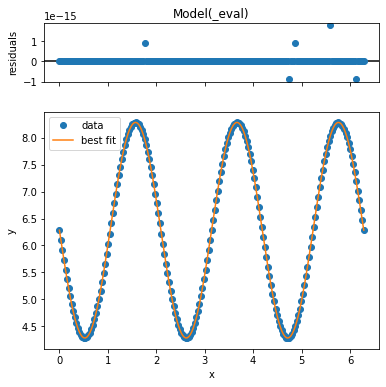

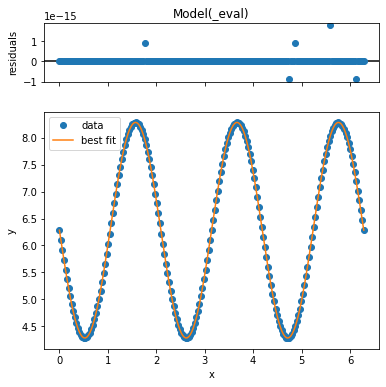

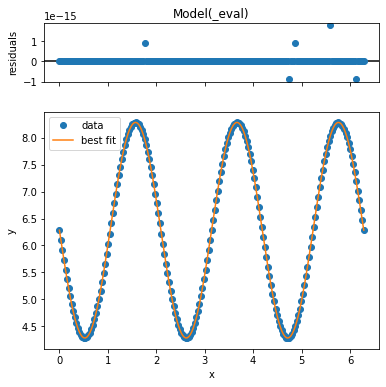

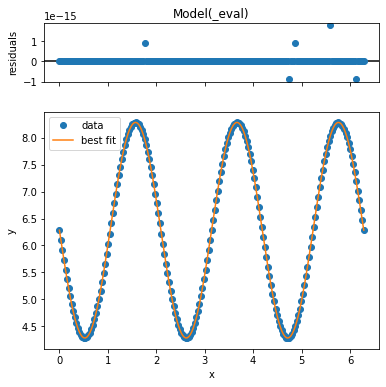

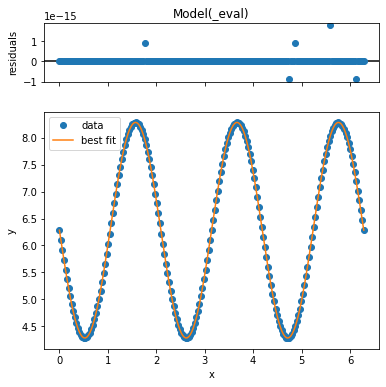

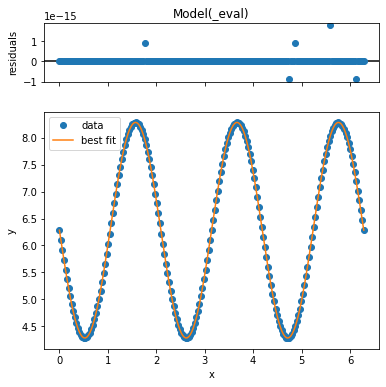

In [3]:
N = 200
Nt = 50
dx = 2 * np.pi / N
dt = 1 / Nt
r = dt / (dx * dx)



time_steps = 400
time = np.arange(0, (time_steps + .5) * dt, dt)
x = np.arange(0, 2 * np.pi + dx / 2, dx)
# x = np.arange(0, L, dx)
lamba = dt / dx

# Lax-Wendroff sln
w = np.zeros((N + 1, time_steps + 1))

# Lax sln
a = np.zeros((N + 1, time_steps + 1))

n = 3 # number of nodes
# const = np.pi/n
const = 0 # phase constant?
v = 1 # wave speed
rad = 2*np.pi # radius of circle
# rad = 5 # radius of circle
L = 2*np.pi + dx # length of the system
# L = 10 # length of the system

ipos = np.zeros(N + 1)
ineg = np.zeros(N + 1)


# Initial Conditions

initCond = 'stand'
if initCond == 'sine':
    for i in range(0, N + 1):

    #     w[i, 0] = rad + 1 * (np.sin(n*x[i] - i*v) + np.sin(n*x[i] + i*v)) 
    #     a[i, 0] = rad + 1 * (np.sin(n*x[i] - i*v) + np.sin(n*x[i] + i*v))
        w[i, 0] = 1.1*np.sin((x[i] - const)*(2*np.pi*n)/L)
        a[i, 0] = 1.1*np.sin((x[i] - const)*(2*np.pi*n)/L)

elif initCond == 'stand':
    for i in range(0, N + 1):
        w[i, 0] = (rad + -1 * (np.sin(n*x[i] - const) + np.sin(n*x[i] + const)))
        a[i, 0] = (rad + -1 * (np.sin(n*x[i] - const) + np.sin(n*x[i] + const)))
#         w[i, 0] = rad + 1 * (np.sin(n*np.pi*x[i]/L) + np.sin(n*np.pi*x[i]/L)) 
#         a[i, 0] = rad + 1 * (np.sin(n*np.pi*x[i]/L) + np.sin(n*np.pi*x[i]/L))
#         w[i, 0] = rad + 1 * (np.sin(2*n*np.pi*x[i]) + np.sin(2*n*np.pi*x[i])) 
#         a[i, 0] = rad + 1 * (np.sin(2*n*np.pi*x[i]) + np.sin(2*n*np.pi*x[i]))
# for i in range(0, N + 1):
#     ipos[i] = int(i + 1)
#     ineg[i] = int(i - 1)

# ipos[N] = 0
# ineg[0] = 0


# a[0, :] = rad
# a[-1, :] = rad
# w[0, :] = rad
# w[-1, :] = rad
for j in range(0, time_steps):
    for i in range(0, N + 1):

        a[i, j + 1] = a[i, j] - lamba / 2 * (
            a[int(ipos[i]), j] - a[int(ineg[i]), j])
        

        w[i, j + 1] = w[i, j] - lamba / 2 * (
            w[int(ipos[i]), j] - w[int(ineg[i]), j]) + lamba * lamba / 2 * (
                w[int(ipos[i]), j] - 2 * w[i, j] + w[int(ineg[i]), j]) / 2
        
sineModel = lmfit.models.ExpressionModel("C + A*sin(n*x)*cos(n*t)")
params = sineModel.make_params(C=rad, A=5, n=3, t = 0)

# for i in range(time_steps + 1):
for i in range(6):
    sineResult = sineModel.fit(a[:, i], params, x=x)
#     print(sineResult.chisqr)
#     print(sineResult.redchi)
#     print(sineResult.fit_report())
    sineResult.plot()
    plt.show()

# sineResult.params.pretty_print()

6.310887241768095e-30
3.203496061811215e-32


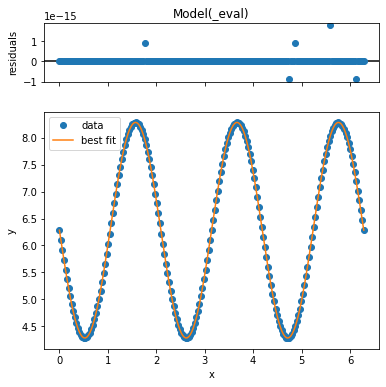

In [4]:
# plt.plot(x, sineResult.best_fit, label = f'sine fit, $\chi^2_r$ = {sineResult.redchi:.3f}')
sineResult.plot()
# sineResult.fit_report()
# sineResult.params.pretty_print()
print(sineResult.chisqr)
print(sineResult.redchi)

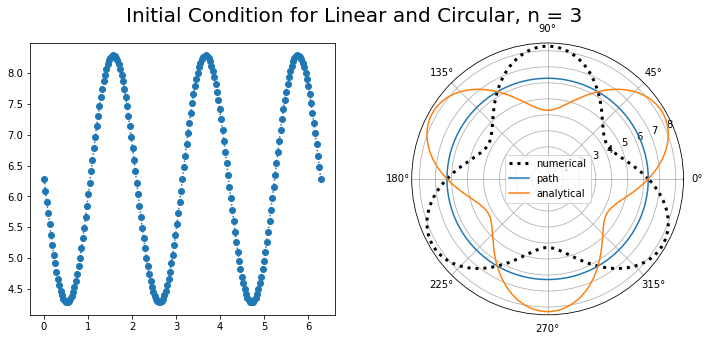

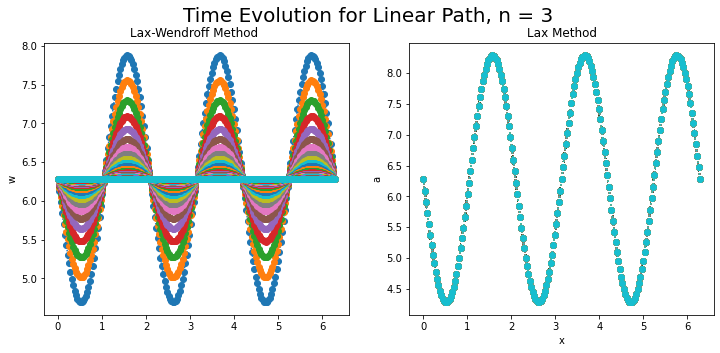

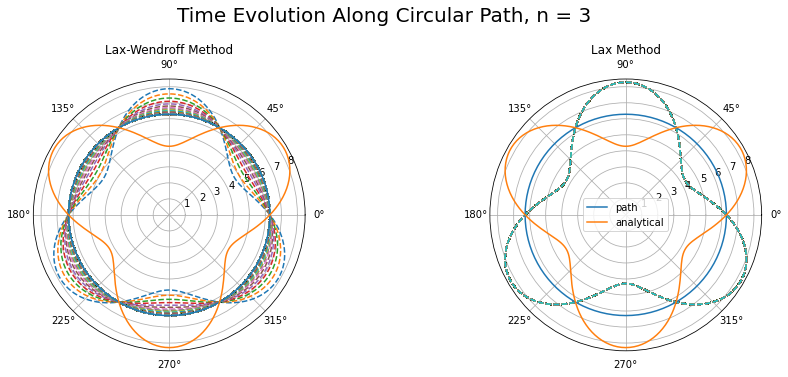

In [5]:
fig0 = plt.figure(figsize = (12, 5))
ax00 = plt.subplot(121)
ax01 = plt.subplot(122, projection = 'polar')
ax00.plot(x, w[:, 0], 'o:', label='Initial Condition')
# ax00.xlim([-0.1, max(x) + dx])
# plt.title(f'Intitial Condition, n = {n}', fontsize=24)
# plt.xlabel('x')
# plt.ylabel('w')
# plt.legend(loc='best')
# plt.show()

# fig1, ax1 = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': 'polar'}, figsize = (10, 8))

ax01.plot(x, w[:, 0], 'k:', label = 'numerical', linewidth = 3)
ax01.plot(x, rad * np.ones(len(x)), label = 'path')
# ax01.plot(x, rad + np.sin(n*x - const) + np.sin(n*x  const), label = 'analytical')
ax01.plot(x, rad + 2*np.sin(n*x), label = 'analytical')
ax01.grid(True)
ax01.legend()

plt.suptitle(f"Initial Condition for Linear and Circular, n = {n}", fontsize=20)
# plt.show()

fig2, ax2 = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 5))
for j in range(1, time_steps + 1):
    ax2[0].plot(x, w[:, j], 'o:')
    ax2[1].plot(x, a[:, j], 'o:')
plt.xlabel('x')
ax2[0].set_ylabel('w')
ax2[0].set_title(f'Lax-Wendroff Method ')
ax2[1].set_ylabel('a')
ax2[1].set_title(f'Lax Method')
plt.suptitle(f'Time Evolution for Linear Path, n = {n}' , fontsize=20)
# plt.show()

fig3, ax3 = plt.subplots(nrows=1, ncols = 2, subplot_kw={'projection': 'polar'}, figsize = (15, 5))
for j in range(1, time_steps + 1):
#     ax3[0].plot(x, rad + w[:, j], '--')
#     ax3[1].plot(x, rad + a[:, j], '--')
    ax3[0].plot(x, w[:, j], '--')
    ax3[1].plot(x, a[:, j], '--')
ax3[0].plot(x, rad * np.ones(len(x)), label = 'path')
ax3[0].plot(x, rad + 2*np.sin(n*x), label = 'analytical')
ax3[0].set_title('Lax-Wendroff Method')

ax3[1].plot(x, rad * np.ones(len(x)), label = 'path')
ax3[1].plot(x, rad + 2*np.sin(n*x), label = 'analytical')
ax3[1].legend()
ax3[1].set_title('Lax Method')
plt.suptitle(f'Time Evolution Along Circular Path, n = {n}', fontsize=20, y = 1.08)

plt.show()